In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.4/223.4 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
from darts import TimeSeries
from darts.models import NBEATSModel
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet, MultiTaskElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, MultiTaskLassoCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from numpy.linalg import inv
# from tensorflow import keras
# from tensorflow.keras import layers


def embedTS(TS,n,H):
    N,m=TS.shape
    for i in np.arange(N - n - H - 1):
        Xi = TS[i:(i + n), 0].reshape(1, -1)
        Yi = TS[(n + i):(i + n + H), 0].reshape(1, -1)
        for j in np.arange(1, m):
            Xi = np.hstack((Xi, TS[i:(i + n), j].reshape(1, -1)))
            Yi = np.hstack((Yi, TS[(n + i):(i + n + H), j].reshape(1, -1)))
        if i == 0:
            X = Xi
            Y = Yi
        else:
            X = np.vstack((X, Xi.reshape(1, -1)))
            Y = np.vstack((Y, Yi.reshape(1, -1)))
    return X,Y





def foreSL(mod,TS,n,H):
    m=TS.shape[1]
    X,Y=embedTS(TS,n=n,H=H)
    q=TS[-n:,:].reshape(1,-1,order="F")
    yhat=pred(mod,X,Y,q)
    yhatr=yhat.reshape(H,m,order="F")
    return yhatr

def pred(mod,X,Y,Xts):
    N,m=Y.shape
    cvfold=3
    npars=10
    niters=30
    if (mod=="RidgeCV"):
        model = RidgeCV(alphas=np.linspace(0.1, 100, num = npars))
        model.fit(X, Y)

    if (mod=="LassoCV"):
        if m==1:
            model = LassoCV(cv=cvfold, random_state=0).fit(X, Y)
        else:
            model = MultiTaskLassoCV(cv=cvfold, random_state=0,max_iter=niters,
                       verbose=0).fit(X, Y)
        model.fit(X, Y)

    if (mod=="EnetCV"):

        if m==1:
            model = ElasticNet(random_state=0).fit(X, Y)
        else:
            random_grid = {'alpha': [int(x) for x in np.linspace(0.1, 2, num = npars)]}
            model =MultiTaskElasticNet()
            model = RandomizedSearchCV(estimator = model, param_distributions = random_grid,
                             n_iter = niters, cv = cvfold, verbose=0, random_state=42)
        model.fit(X, Y)


    if (mod=="Keras"):
        def build_model():
            model = keras.Sequential([
                layers.Dense(4, activation="relu"),
                layers.Dropout(0.95),
                layers.Dense(2, activation="relu"),
                layers.Dense(m)
            ])
            model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
            return model

        model = build_model()
        model.fit(X, Y,
              epochs=500, batch_size=10, verbose=0, validation_split=0.2)


    if (mod=="RF"):

        model = RandomForestRegressor()
        model.fit(X, Y)


    if (mod=="KNN"):
        # Create the random grid
        random_grid = {'n_neighbors': [int(x) for x in np.linspace(1, 20, num = npars)],
                   'weights':['uniform', 'distance']}
        knn_r = KNeighborsRegressor()

        model = RandomizedSearchCV(estimator = knn_r, param_distributions = random_grid,
                                       n_iter = niters, cv = cvfold, verbose=0, random_state=42)
        model.fit(X, Y)


    if (mod=="GBR"):
        if m>1:
            gb_regressor = RegressorChain(base_estimator=GradientBoostingRegressor(), order='random')
            random_grid = {'base_estimator__n_estimators': [int(x) for x in np.linspace(1, 50, num = npars)]}
        else:
            gb_regressor = GradientBoostingRegressor()
            random_grid = {'n_estimators': [int(x) for x in np.linspace(1, 50, num = npars)]}
        model = RandomizedSearchCV(estimator = gb_regressor, param_distributions = random_grid,
                                      n_iter = niters, cv = cvfold, verbose=0, random_state=42)
        model.fit(X, Y)

    if (mod=="ABR"):
        if m>1:
            ab_regressor = MultiOutputRegressor(AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                                                              n_estimators=400, random_state=7))
            random_grid = {'estimator__base_estimator__max_depth': [int(x) for x in np.linspace(1, 10, num = npars)]}
        else:
            ab_regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=400, random_state=7)
            random_grid = {'base_estimator__max_depth': [int(x) for x in np.linspace(1, 10, num = npars)]}

        model = RandomizedSearchCV(estimator = ab_regressor, param_distributions = random_grid,
                                      n_iter = niters, cv = cvfold, verbose=1, random_state=42)
        model.fit(X, Y)


    if (mod=="PLS"):
        random_grid = {'n_components': [int(x) for x in np.linspace(1, 20, num = npars)]}
        reg = PLSRegression()

        model = RandomizedSearchCV(estimator = reg, param_distributions = random_grid,
                                       n_iter = niters, cv = cvfold, verbose=0, random_state=42)

        model.fit(X, Y)


    if (mod=="PipeRF"):
        model = Pipeline([
        ('feature_selection', SelectFromModel(RandomForestRegressor())),
        ('regression', RandomForestRegressor())
        ])
        model.fit(X, Y)

    if (mod=="PipeKNN"):
        knn_r = Pipeline([
            ('feature_selection', SelectFromModel(RandomForestRegressor())),
            ('regression', KNeighborsRegressor())
        ])
        random_grid = {'feature_selection__max_features': [int(x) for x in np.linspace(1, 10, num = 3)],
                       'regression__n_neighbors': [int(x) for x in np.linspace(1, 20, num = 5)]}
        model = RandomizedSearchCV(estimator = knn_r, param_distributions = random_grid,
                                           n_iter = niters, cv = 3, verbose=0, random_state=42)
        model.fit(X, Y)

    if (mod=="PressRidge"):
        N,n=X.shape
        Nts,n=Xts.shape
        XX=np.hstack((np.ones((N,1)),X))
        XXts=np.hstack((np.ones((Nts,1)),Xts))
        I=np.diag(np.ones(n+1))
        mseloo=[]
        LAM=np.linspace(start=0.01, stop=100, num=npars)
        for lam in LAM:
            IX=inv(np.matmul(XX.T,XX)+lam*I)
            H=np.matmul(np.matmul(XX,IX),XX.T)
            betahat=np.matmul(np.matmul(IX,XX.T),Y)
            Yhat=np.matmul(H,Y)
            e=Y-Yhat
            eloo=np.copy(e)
            for j in np.arange(m):
                eloo[:,j]=e[:,j]/(1-np.diag(H))
            mseloo.append(np.mean(pow(eloo,2.0)))
        lmin=np.argmin(np.array(mseloo))
        bestlam=LAM[lmin]
        IX=inv(np.matmul(XX.T,XX)+bestlam*I)
        H=np.matmul(np.matmul(XX,IX),XX.T)
        betahat=np.matmul(np.matmul(IX,XX.T),Y)
        yhat=np.matmul(XXts,betahat)
        return yhat

    yhat = model.predict(Xts)
    return yhat


def fdarts(mod,TS,n,H,nepochs=50,nunits=10):
    m=TS.shape[1]
    if (mod=="NBEATS"):
        series=TimeSeries.from_values(TS)
        model = NBEATSModel(input_chunk_length=max(H+1,5*n),output_chunk_length=H, random_state=42)
        #    force_reset=True,
        #    pl_trainer_kwargs={
        #      "accelerator": "gpu",
        #      "devices": [0]
        #    } )

        model.fit(series,epochs=nepochs,verbose=False)
        forecast = model.predict(H,verbose=False)
        yhat=np.array(forecast.pd_dataframe().values)

    if (mod=="TFT"):
        from darts.models import TransformerModel
        series=TimeSeries.from_values(TS)
        model = TransformerModel(
            batch_size=32,
            input_chunk_length=max(H+1,5*n),
            output_chunk_length=H,
            n_epochs=nepochs,
            model_name="transformer",
            nr_epochs_val_period=5,
            d_model=16,
            nhead=4,
            num_encoder_layers=2,
            num_decoder_layers=2,
            dim_feedforward=nunits,
            dropout=0.1,
            random_state=42,
            optimizer_kwargs={"lr": 1e-3},
            save_checkpoints=False,
            force_reset=True,
        )
        model.fit(series,epochs=nepochs,verbose=False)
        forecast = model.predict(H,verbose=False)
        yhat=np.array(forecast.pd_dataframe().values)

    if (mod=="NHITS"):
        from darts.models import NHiTSModel
        series=TimeSeries.from_values(TS)

        model = NHiTSModel(input_chunk_length=max(H+1,5*n),
                   output_chunk_length=H,n_epochs=nepochs,)
        model.fit(series,epochs=nepochs,verbose=False)
        forecast = model.predict(H,verbose=False)
        yhat=np.array(forecast.pd_dataframe().values)

    if (mod=="TCM"):
        from darts.models import TCNModel
        series=TimeSeries.from_values(TS)


        model = TCNModel(input_chunk_length=max(H+1,5*n),
                         output_chunk_length=H,n_epochs=nepochs,)
        model.fit(series,epochs=nepochs,verbose=False)
        forecast = model.predict(H,verbose=False)
        yhat=np.array(forecast.pd_dataframe().values)

    if (mod=="RNN"):
        from darts.models import RNNModel
        series=TimeSeries.from_values(TS)
        model = RNNModel(input_chunk_length=max(H+1,5*n),
                         output_chunk_length=H,n_epochs=nepochs)
        model.fit(series,epochs=nepochs,verbose=False)
        forecast = model.predict(H,verbose=False)
        yhat=np.array(forecast.pd_dataframe().values)

    if (mod=="BlockRNN"):
        from darts.models import BlockRNNModel
        series=TimeSeries.from_values(TS)
        model = BlockRNNModel(input_chunk_length=max(H+1,5*n),
                              output_chunk_length=H,n_epochs=nepochs,)
        model.fit(series,epochs=nepochs,verbose=False)
        forecast = model.predict(H,verbose=False)
        yhat=np.array(forecast.pd_dataframe().values)

    if (mod=="LightGBM"):
        from darts.models import LightGBMModel
        series=TimeSeries.from_values(TS)
        model = LightGBMModel(lags=n)
        model.fit(series,verbose=False)
        forecast = model.predict(H)
        yhat=np.array(forecast.pd_dataframe().values)


    if (mod=="XGBM"):
        from darts.models import XGBModel
        series=TimeSeries.from_values(TS)
        model = XGBModel(lags=n)
        model.fit(series,verbose=False)
        forecast = model.predict(H)
        yhat=np.array(forecast.pd_dataframe().values)

    if (mod=="RF"):
        from darts.models import RandomForest
        series=TimeSeries.from_values(TS)
        model = RandomForest(lags=n)
        model.fit(series)
        forecast = model.predict(H)
        yhat=np.array(forecast.pd_dataframe().values)

    if (mod=="ES"):
        from darts.models import ExponentialSmoothing
        yhat=np.zeros((H,m))
        for j in np.arange(m):
            series=TimeSeries.from_values(TS[:,j])
            model = ExponentialSmoothing()
            model.fit(series)
            forecast = model.predict(H)
            yhat[:,j]=np.array(forecast.pd_dataframe().values).reshape(H,)

    if (mod=="Theta"):
        from darts.models import FourTheta
        yhat=np.zeros((H,m))
        for j in np.arange(m):
            series=TimeSeries.from_values(TS[:,j])
            model = FourTheta()
            model.fit(series)
            forecast = model.predict(H)
            yhat[:,j]=np.array(forecast.pd_dataframe().values).reshape(H,)

    if (mod=="ARIMA"):
        from darts.models import StatsForecastAutoARIMA
        yhat=np.zeros((H,m))
        for j in np.arange(m):
            series=TimeSeries.from_values(TS[:,j])
            model = StatsForecastAutoARIMA(season_length=12)
            model.fit(series)
            forecast = model.predict(H)
            yhat[:,j]=np.array(forecast.pd_dataframe().values).reshape(H,)

    if (mod=="ETS"):
        from darts.models import StatsForecastETS
        yhat=np.zeros((H,m))
        for j in np.arange(m):
            series=TimeSeries.from_values(TS[:,j])
            model = StatsForecastETS( model="AZZ")
            model.fit(series)
            forecast = model.predict(H)
            yhat[:,j]=np.array(forecast.pd_dataframe().values).reshape(H,)

    if (mod=="BATS"):
        from darts.models import BATS
        yhat=np.zeros((H,m))
        for j in np.arange(m):
            series=TimeSeries.from_values(TS[:,j])
            model = BATS()
            model.fit(series)
            forecast = model.predict(H)
            yhat[:,j]=np.array(forecast.pd_dataframe().values).reshape(H,)

    return yhat

In [ ]:
import sys;
print('Python %s on %s' % (sys.version, sys.platform))

import numpy as np
import sklearn
import pandas
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


import warnings
import pickle
warnings.filterwarnings('ignore')
MSE=[]
for ff in [1]: #np.arange(1,50):
    #namefile='/content/gdrive/MyDrive/ColabData/sdata/s.'+str(ff)+'.csv'
    namefile='/content/gdrive/MyDrive/Mobility data/Mobility data/dataset/dataset/matrix form/traffic counts/output_15min_10apr23_matrix.csv'
    TS = np.array(pandas.read_csv(namefile,sep=";"))
    N,m=TS.shape
    print("ff=",ff, "N=",N,"m=",m)
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_mean.fit(TS)
    TS=imp_mean.transform(TS)
    TS=TS[:, 0:6]
    TS=sklearn.preprocessing.scale(TS)
    #print(pandas.DataFrame(TS).mean())
    N,m=TS.shape
    print("ff=",ff, "N=",N,"m=",m)
    n=2
    H=8
    DartsModels=["NHITS","ES","ARIMA"]#,"ETS","BATS"]

    Models=["PressRidge","PipeRF","PipeKNN","RidgeCV","EnetCV","LassoCV","RF","KNN","GBR","PLS"]
    for Ntr in np.linspace(start=int(N/3), stop=N-2*H, num=10).astype(int):
        TStr=TS[:Ntr,0:6]
        TSts=TS[Ntr:(Ntr+H),0:6]

        mse=[]


        for mm in DartsModels:
            YY=fdarts(mm,TStr,n,H)
            E=YY-TSts
            print(ff, mm ," MSE=",np.mean(pow(E,2.0)))
            mse.append(np.mean(pow(E,2.0)))

        for mm in Models:
            Yhat=foreSL(mm,TStr,n,H=H)
            E=Yhat-TSts
            print(ff, mm," MSE=",np.mean(pow(E,2.0)))
            mse.append(np.mean(pow(E,2.0)))

        if (len(MSE)==0):
            MSE=np.array(mse)
        else:
            MSE=np.vstack((MSE,np.array(mse)))

        MSEdf=pandas.DataFrame(MSE.reshape(-1,len(DartsModels+Models)),columns=DartsModels+Models)
        #print(MSEdf)
        #print(MSEdf.mean())
        MSEdf.to_pickle("./MSEn2h8.pdata")
        #unpickled_df = pandas.read_pickle("./MSEn1h1.pdata")
        #plt.clf()
        #plt.plot(np.arange(Ntr+H),TS[:(Ntr+H),0],"b")
        #plt.plot(np.arange(Ntr+H),np.concatenate((TStr.reshape(-1,1),Yhat.reshape(-1,1))),"r")
        #plt.plot(np.arange(Ntr+H),np.concatenate((TStr.reshape(-1,1),Yhat2.reshape(-1,1))),"g")
        #plt.show()

Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] on linux
ff= 1 N= 1590 m= 75
ff= 1 N= 1590 m= 6


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


1 NHITS  MSE= 0.1570726881790095
1 ES  MSE= 0.20005308032457922
1 ARIMA  MSE= 0.1222563642687616
1 PressRidge  MSE= 0.19074736858123784
1 PipeRF  MSE= 0.23369986252222646
1 PipeKNN  MSE= 0.07596602113728927
1 RidgeCV  MSE= 0.19113411406716907
1 EnetCV  MSE= 0.19074475229823043
1 LassoCV  MSE= 0.2181890497515336
1 RF  MSE= 0.14159220361090624
1 KNN  MSE= 0.20304194508165124
1 GBR  MSE= 0.6276926537878176
1 PLS  MSE= 0.24935093887752535


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


1 NHITS  MSE= 0.09417729530912156
1 ES  MSE= 0.5353858039693429
1 ARIMA  MSE= 0.186997559502894
1 PressRidge  MSE= 0.08259134147360506
1 PipeRF  MSE= 0.36384271971940035
1 PipeKNN  MSE= 0.14422574262158425
1 RidgeCV  MSE= 0.0826375474637374
1 EnetCV  MSE= 0.08258841706000059
1 LassoCV  MSE= 0.17071660879988113
1 RF  MSE= 0.3221547648971408
1 KNN  MSE= 0.18434353957913205
1 GBR  MSE= 0.3536251052412078
1 PLS  MSE= 0.08346822028193099


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


1 NHITS  MSE= 0.05371977316126261
1 ES  MSE= 3.1599311315634053
1 ARIMA  MSE= 0.2547788374177466
1 PressRidge  MSE= 0.16256636261476176
1 PipeRF  MSE= 1.1017291818074941
1 PipeKNN  MSE= 0.1262015684570656
1 RidgeCV  MSE= 0.16236868756947234
1 EnetCV  MSE= 0.16258827050776872
1 LassoCV  MSE= 0.14469347654586903
1 RF  MSE= 0.29913376067646463
1 KNN  MSE= 0.09186971636008506
1 GBR  MSE= 0.10330129249849648
1 PLS  MSE= 0.16869326005879487


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


1 NHITS  MSE= 0.17340813607012365
1 ES  MSE= 0.19973944215687528
1 ARIMA  MSE= 0.22278365756189455
1 PressRidge  MSE= 0.205798403613562
1 PipeRF  MSE= 0.3106939694454818
1 PipeKNN  MSE= 0.1286153430501086
1 RidgeCV  MSE= 0.2054589794255046
1 EnetCV  MSE= 0.20583527501018692
1 LassoCV  MSE= 0.1373769046064013
1 RF  MSE= 0.40741172514578544
1 KNN  MSE= 1.507444477564106
1 GBR  MSE= 0.13756176114869717
1 PLS  MSE= 0.13122370428008193


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


1 NHITS  MSE= 0.623988521262387
1 ES  MSE= 0.5939612741190362
1 ARIMA  MSE= 0.39324987724655935
1 PressRidge  MSE= 0.3298453781075089
1 PipeRF  MSE= 0.5026527432914857
1 PipeKNN  MSE= 0.2718421852209973
1 RidgeCV  MSE= 0.32932300647586
1 EnetCV  MSE= 0.32990249419394646
1 LassoCV  MSE= 0.27451345068114397
1 RF  MSE= 0.29333262706456453
1 KNN  MSE= 0.20943110517800573
1 GBR  MSE= 0.15545594407308136
1 PLS  MSE= 0.35304258144415135


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


1 NHITS  MSE= 0.24410876599965475
1 ES  MSE= 0.4437061378239695
1 ARIMA  MSE= 0.46280646322789754
1 PressRidge  MSE= 0.18091896566773155
1 PipeRF  MSE= 0.868062299199781
1 PipeKNN  MSE= 0.5402334739802216
1 RidgeCV  MSE= 0.18138666013839683
1 EnetCV  MSE= 0.1808683384663196
1 LassoCV  MSE= 0.42481235101110565
1 RF  MSE= 0.17101197967349485
1 KNN  MSE= 0.1801702275562606
1 GBR  MSE= 1.1724270283871048
1 PLS  MSE= 0.1834678748407908


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


1 NHITS  MSE= 0.03979992713044658
1 ES  MSE= 0.07955243754394305
1 ARIMA  MSE= 0.06573770971853049
1 PressRidge  MSE= 0.1394393673822278
1 PipeRF  MSE= 0.4651751648430264
1 PipeKNN  MSE= 0.06497233975542797
1 RidgeCV  MSE= 0.13939084312473857
1 EnetCV  MSE= 0.13944511680520452
1 LassoCV  MSE= 0.14265328734403887
1 RF  MSE= 0.23360807499452313
1 KNN  MSE= 0.03255910319119301
1 GBR  MSE= 0.023360173771194113
1 PLS  MSE= 0.13954678749160326


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


1 NHITS  MSE= 0.12214344335947028
1 ES  MSE= 1.9669689642593249
1 ARIMA  MSE= 0.20095876046807304
1 PressRidge  MSE= 0.2233052275032185
1 PipeRF  MSE= 0.49759080266716205
1 PipeKNN  MSE= 0.12563156863849914
1 RidgeCV  MSE= 0.22288209951112892
1 EnetCV  MSE= 0.22335231023217123
1 LassoCV  MSE= 0.14560411349233415
1 RF  MSE= 0.3621527354104939
1 KNN  MSE= 0.16284077084103296
1 GBR  MSE= 0.08476705645590296
1 PLS  MSE= 0.22372759300888959


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


1 NHITS  MSE= 0.07300888964916391
1 ES  MSE= 0.3939833858627612
1 ARIMA  MSE= 0.4439620234887869
1 PressRidge  MSE= 0.33649930777033665
1 PipeRF  MSE= 0.6863144972809888
1 PipeKNN  MSE= 0.20325511684991868
1 RidgeCV  MSE= 0.33624447523497436
1 EnetCV  MSE= 0.3365277174021649
1 LassoCV  MSE= 0.3461066624342778
1 RF  MSE= 0.15658743594534547
1 KNN  MSE= 0.08726477265889976
1 GBR  MSE= 0.21023772527151102
1 PLS  MSE= 0.327339399471276


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


1 NHITS  MSE= 0.06595210324997268
1 ES  MSE= 0.6971594150575446
1 ARIMA  MSE= 0.4142476001308386
1 PressRidge  MSE= 0.09179021759835816
1 PipeRF  MSE= 0.5474892813036937
1 PipeKNN  MSE= 0.3408903734426588
1 RidgeCV  MSE= 0.09180226756610461
1 EnetCV  MSE= 0.09178888389702912
1 LassoCV  MSE= 0.10404045697644829
1 RF  MSE= 0.14886471601914583
1 KNN  MSE= 0.13635288828157152
1 GBR  MSE= 0.24688227429045395
1 PLS  MSE= 0.09055230963515244


In [ ]:
df1=pandas.read_pickle("./MSEn2h1.pdata")
df1

,NHITS,ES,ARIMA,PressRidge,PipeRF,PipeKNN,RidgeCV,EnetCV,LassoCV,RF,KNN,GBR,PLS
0,0.197466,0.194425,0.171897,0.142622,0.680299,0.547560,0.142377,0.142652,0.112095,0.152380,0.123836,0.094186,0.142652
1,0.001938,0.003058,0.003822,0.004261,0.084118,0.183061,0.004258,0.004261,0.002241,0.005830,0.003851,0.003832,0.004261
2,0.029490,0.117710,0.101212,0.054120,0.202190,0.178000,0.054039,0.054129,0.070042,0.044628,0.056352,0.028577,0.054129
3,0.088680,0.072066,0.075019,0.051113,0.152951,0.201625,0.051025,0.051122,0.057165,0.089394,0.037581,0.034520,0.051122
4,0.030232,0.113514,0.106993,0.138950,1.084160,0.491780,0.138963,0.138948,0.138113,0.134044,0.153760,0.110402,0.138948
5,0.008787,0.018965,0.019376,0.016479,0.414204,0.277512,0.016454,0.016482,0.013379,0.082395,0.018195,0.011705,0.016482
6,0.008701,0.027217,0.019888,0.017214,0.166960,0.049273,0.017216,0.017214,0.016235,0.025177,0.086483,0.005453,0.017214
7,0.083577,0.007405,0.010649,0.011293,0.036621,0.020855,0.011275,0.011295,0.008799,0.022116,0.012971,0.006898,0.011295
8,0.095962,0.170632,0.163844,0.135421,0.105180,0.351336,0.135448,0.135418,0.144923,0.152085,0.063157,0.137141,0.135418
9,0.002361,0.012515,0.015621,0.010597,0.010746,0.011305,0.010595,0.010598,0.011290,0.012962,0.008430,0.009292,0.010598


In [ ]:
df2=pandas.read_pickle("./MSEn2h2.pdata")
df2

,NHITS,ES,ARIMA,PressRidge,PipeRF,PipeKNN,RidgeCV,EnetCV,LassoCV,RF,KNN,GBR,PLS
0,0.219206,0.212263,0.164056,0.137907,0.669378,0.825652,0.137686,0.137934,0.110080,0.141478,0.103236,0.098779,0.137934
1,0.003868,0.004249,0.004460,0.005583,0.178342,0.219243,0.005588,0.005583,0.003850,0.005876,0.004201,0.004076,0.005554
2,0.139220,0.064974,0.045900,0.025529,0.244490,0.258807,0.025529,0.025529,0.024183,0.052988,0.062705,0.035227,0.025529
3,0.092719,0.117692,0.119343,0.078510,0.202451,0.218582,0.078384,0.078525,0.078596,0.097123,0.083603,0.074561,0.078525
4,0.013497,0.055396,0.055218,0.055778,0.399904,0.636063,0.055937,0.055761,0.073576,0.113176,0.068874,0.024003,0.055761
5,0.032754,0.031382,0.027338,0.011414,0.482273,0.605812,0.011417,0.011414,0.011134,0.111014,0.086465,0.011688,0.011414
6,0.024070,0.038096,0.024651,0.025076,0.059123,0.065831,0.025073,0.025077,0.023511,0.045356,0.076027,0.020983,0.025077
7,0.042035,0.017238,0.011002,0.026203,0.057816,0.029770,0.026114,0.026213,0.015879,0.033386,0.018872,0.016390,0.026213
8,0.075168,0.043924,0.048927,0.047705,0.164479,0.149197,0.047715,0.047703,0.055456,0.140646,0.155752,0.101754,0.047703
9,0.008990,0.012938,0.019760,0.015774,0.039098,0.017922,0.015796,0.015772,0.020228,0.028918,0.014492,0.016742,0.015772


In [ ]:
df3=pandas.read_pickle("./MSEn2h3.pdata")
df3

,NHITS,ES,ARIMA,PressRidge,PipeRF,PipeKNN,RidgeCV,EnetCV,LassoCV,RF,KNN,GBR,PLS
0,0.163722,0.159948,0.120508,0.102819,0.613625,0.505739,0.102639,0.102839,0.082256,0.108525,0.082250,0.088874,0.102839
1,0.010810,0.004625,0.007658,0.007795,0.007495,0.017721,0.007804,0.007796,0.005907,0.014295,0.004718,0.008394,0.007772
2,0.146230,0.168926,0.125962,0.071224,0.163341,0.184183,0.071115,0.071236,0.065915,0.066443,0.081425,0.093897,0.071236
3,0.094886,0.070305,0.081817,0.097350,0.110784,0.091297,0.097375,0.097347,0.101301,0.123263,0.145291,0.097110,0.097347
4,0.037945,0.154551,0.104978,0.114095,0.551654,0.496194,0.114297,0.114073,0.151156,0.160010,0.127987,0.162062,0.114073
5,0.039700,0.032157,0.040535,0.022957,0.285011,0.077948,0.022988,0.022953,0.023350,0.187760,0.071819,0.064863,0.022953
6,0.009481,0.017420,0.016226,0.010088,0.017027,0.032786,0.010080,0.010089,0.008990,0.019661,0.032138,0.021788,0.010089
7,0.050955,0.085999,0.091073,0.072220,0.025962,0.054008,0.072211,0.072221,0.075667,0.036468,0.071723,0.031241,0.072221
8,0.088795,0.162944,0.153328,0.114792,0.262679,0.121083,0.114824,0.114788,0.127534,0.222221,0.200923,0.197851,0.114788
9,0.006218,0.014173,0.029136,0.010048,0.029168,0.011581,0.010071,0.010046,0.016436,0.020155,0.020327,0.009616,0.010046


In [ ]:
df4=pandas.read_pickle("./MSEn2h4.pdata")
df4

,NHITS,ES,ARIMA,PressRidge,PipeRF,PipeKNN,RidgeCV,EnetCV,LassoCV,RF,KNN,GBR,PLS
0,0.132580,0.144732,0.111046,0.096582,0.160711,0.099186,0.096418,0.096599,0.079878,0.124299,0.091348,0.121875,0.096599
1,0.006061,0.006791,0.013905,0.011165,0.043990,0.011146,0.011166,0.011168,0.008700,0.124126,0.008285,0.033051,0.011173
2,0.134033,0.114157,0.101661,0.102291,0.116204,0.192921,0.102163,0.102305,0.084686,0.147317,0.099368,0.075784,0.102305
3,0.123047,0.053187,0.068786,0.076496,0.111956,0.137244,0.076615,0.076482,0.094663,0.115345,0.120222,0.088355,0.076482
4,0.145265,0.234518,0.242510,0.328074,0.423193,0.172827,0.328087,0.328074,0.351327,0.339789,0.704350,0.520792,0.328754
5,0.016765,0.053834,0.067447,0.059154,0.089829,0.082587,0.059155,0.059153,0.053021,0.175200,0.093045,0.030244,0.059153
6,0.009539,0.019729,0.007043,0.011088,0.018392,0.018612,0.011066,0.011090,0.007990,0.021719,0.022149,0.016967,0.011090
7,0.041925,0.058780,0.067274,0.083549,0.026236,0.040855,0.083488,0.083556,0.084153,0.028282,0.037101,0.028364,0.083556
8,0.086942,0.275217,0.279100,0.223637,0.216945,0.143876,0.223602,0.223640,0.216325,0.193641,0.216794,0.227733,0.223640
9,0.010403,0.098641,0.166327,0.111436,0.014833,0.019324,0.111429,0.111437,0.115652,0.017553,0.029837,0.021572,0.111437


In [ ]:
df8=pandas.read_pickle("./MSEn2h8.pdata")
df8

,NHITS,ES,ARIMA,PressRidge,PipeRF,PipeKNN,RidgeCV,EnetCV,LassoCV,RF,KNN,GBR,PLS
0,0.156303,0.133609,0.087212,0.067521,0.201545,0.090488,0.067415,0.067530,0.062864,0.164630,0.171479,0.091003,0.067530
1,0.025525,0.061268,0.031808,0.036970,0.111762,0.058012,0.036876,0.036988,0.029008,0.281443,0.055064,0.039352,0.036451
2,0.066125,0.485154,0.132639,0.076132,0.485963,0.092125,0.076050,0.076142,0.063768,0.183562,0.059759,0.075412,0.076142
3,0.068634,0.139288,0.147787,0.262587,0.112879,0.115866,0.262215,0.262628,0.239716,0.092137,0.128989,0.113932,0.262628
4,0.126083,0.474052,0.303665,0.329967,0.439326,0.327458,0.330017,0.329962,0.400831,0.206045,0.640209,0.521310,0.329962
5,0.061689,0.203062,0.238408,0.131822,0.138927,1.027984,0.132090,0.131792,0.153284,0.156925,0.158320,0.228180,0.133187
6,0.049797,0.027268,0.022549,0.029989,0.014359,0.012768,0.029986,0.029989,0.030421,0.020784,0.067408,0.011497,0.029989
7,0.070283,0.101479,0.110144,0.062341,0.072761,0.107571,0.062212,0.062355,0.047674,0.093524,0.067932,0.039068,0.062355
8,0.058089,0.173969,0.143813,0.165611,0.557538,0.574709,0.165844,0.165586,0.230068,0.629453,0.283481,0.271071,0.165586
9,0.038322,0.680543,0.726349,0.523430,0.112926,0.420672,0.523450,0.523427,0.499965,0.095141,0.123569,0.307855,0.523427


In [ ]:
df1=pandas.read_pickle("./MSEn1h1.pdata")
df1.mean()
df1mean=df1.mean().to_frame()
df1mean.columns=['MSE']
df1mean=df1mean.reset_index(names=['Models','MSE'])
df1mean

,Models,MSE
0,NHITS,0.025038
1,ES,0.001549
2,ARIMA,0.000965
3,PressRidge,0.005303
4,PipeRF,0.046374
5,PipeKNN,0.134358
6,RidgeCV,0.005380
7,EnetCV,0.005295
8,LassoCV,0.006030
9,RF,0.037836


In [ ]:
df2=pandas.read_pickle("./MSEn1h2.pdata")
df2.mean()
df2mean=df2.mean().to_frame()
df2mean.columns=['MSE']
df2mean=df2mean.reset_index(names=['Models','MSE'])
df2mean

,Models,MSE
0,NHITS,0.136217
1,ES,0.088564
2,ARIMA,0.042266
3,PressRidge,0.052886
4,PipeRF,0.023765
5,PipeKNN,0.033574
6,RidgeCV,0.051285
7,EnetCV,0.050720
8,LassoCV,0.053139
9,RF,0.019784


In [ ]:
df3=pandas.read_pickle("./MSEn1h3.pdata")
df3.mean()
df3mean=df3.mean().to_frame()
df3mean.columns=['MSE']
df3mean=df3mean.reset_index(names=['Models','MSE'])
df3mean

,Models,MSE
0,NHITS,0.041214
1,ES,0.009821
2,ARIMA,0.013824
3,PressRidge,0.030870
4,PipeRF,0.065914
5,PipeKNN,0.063808
6,RidgeCV,0.030987
7,EnetCV,0.030857
8,LassoCV,0.033512
9,RF,0.058723


In [ ]:
df4=pandas.read_pickle("./MSEn1h4.pdata")
df4.mean()
df4mean=df4.mean().to_frame()
df4mean.columns=['MSE']
df4mean=df4mean.reset_index(names=['Models','MSE'])
df4mean

,Models,MSE
0,NHITS,0.314689
1,ES,0.116003
2,ARIMA,0.073956
3,PressRidge,0.129946
4,PipeRF,0.179039
5,PipeKNN,0.170227
6,RidgeCV,0.131369
7,EnetCV,0.121847
8,LassoCV,0.133242
9,RF,0.167955


In [ ]:
df5=pandas.read_pickle("./MSEn1h5.pdata")
df5.mean()
df5mean=df5.mean().to_frame()
df5mean.columns=['MSE']
df5mean=df5mean.reset_index(names=['Models','MSE'])
df5mean

,Models,MSE
0,NHITS,0.032134
1,ES,0.042848
2,ARIMA,0.015831
3,PressRidge,0.037175
4,PipeRF,0.042451
5,PipeKNN,0.096598
6,RidgeCV,0.037016
7,EnetCV,0.079860
8,LassoCV,0.035923
9,RF,0.017619


In [ ]:
df6=pandas.read_pickle("./MSEn1h6.pdata")
df6.mean()
df6mean=df6.mean().to_frame()
df6mean.columns=['MSE']
df6mean=df6mean.reset_index(names=['Models','MSE'])
df6mean

,Models,MSE
0,NHITS,0.014023
1,ES,0.013901
2,ARIMA,0.027369
3,PressRidge,0.025625
4,PipeRF,0.054380
5,PipeKNN,0.095136
6,RidgeCV,0.025653
7,EnetCV,0.055929
8,LassoCV,0.030753
9,RF,0.043969


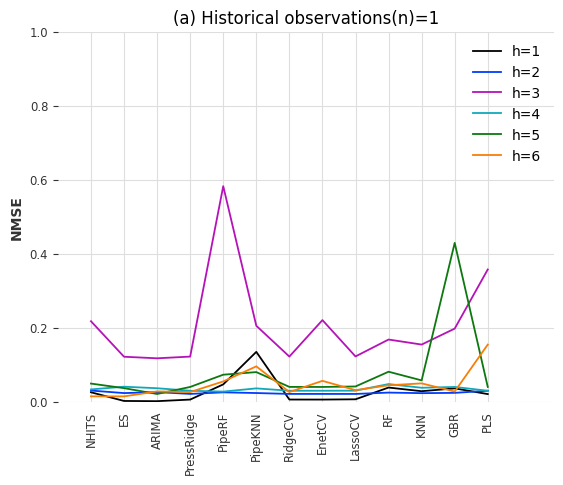

In [ ]:
#n=1
fig,ax = plt.subplots()
x=df1mean.Models
y1=df1mean.MSE
y2=df2mean.MSE
y3=df3mean.MSE
y4=df4mean.MSE
y5=df5mean.MSE
y6=df6mean.MSE
#y7=dfmean7.MSE
ax.plot(x,y1,label="h=1")
ax.plot(x,y2,label="h=2")
ax.plot(x,y3,label="h=3")
ax.plot(x,y4,label="h=4")
ax.plot(x,y5,label="h=5")
ax.plot(x,y6,label="h=6")
#ax.plot(x,y7,label="h=7")
plt.title("(a) Historical observations(n)=1")
plt.ylabel("NMSE")
plt.xticks(rotation=90)
plt.axis([-1, 14, 0, 1])
ax.legend()
plt.show()

In [ ]:
df=pandas.concat([y1,y2,y3,y4,y5,y6], ignore_index=False)
df

0     0.025038
1     0.001549
2     0.000965
3     0.005303
4     0.046374
        ...   
8     0.030753
9     0.043969
10    0.049127
11    0.026996
12    0.154030
Name: MSE, Length: 78, dtype: float64

H=1

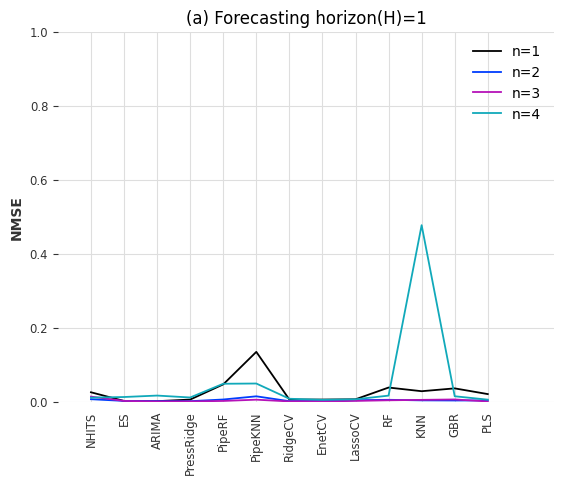

In [ ]:
#H=1
fig,ax = plt.subplots()
x=df1mean.Models
y1=df1mean.MSE
y7=df7mean.MSE
y13=df13mean.MSE
y19=df19mean.MSE
ax.plot(x,y1,label="n=1")
ax.plot(x,y7,label="n=2")
ax.plot(x,y13,label="n=3")
ax.plot(x,y19,label="n=4")
#ax.plot(x,y5,label="h=5")
#ax.plot(x,y6,label="h=6")
#ax.plot(x,y7,label="h=7")
plt.title("(a) Forecasting horizon(H)=1")
plt.ylabel("NMSE")
plt.xticks(rotation=90)
plt.axis([-1, 14, 0, 1])
ax.legend()
plt.show()

H=2

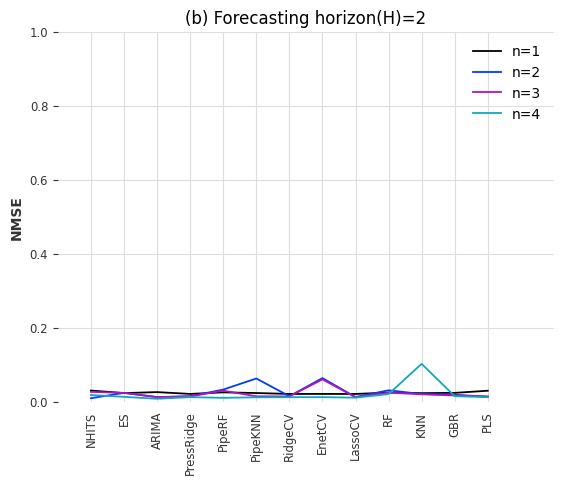

In [ ]:
#H=2
fig,ax = plt.subplots()
x=df1mean.Models
y2=df2mean.MSE
y8=df8mean.MSE
y14=df14mean.MSE
y20=df20mean.MSE
ax.plot(x,y2,label="n=1")
ax.plot(x,y8,label="n=2")
ax.plot(x,y14,label="n=3")
ax.plot(x,y20,label="n=4")
#ax.plot(x,y5,label="h=5")
#ax.plot(x,y6,label="h=6")
#ax.plot(x,y7,label="h=7")
plt.title("(b) Forecasting horizon(H)=2")
plt.ylabel("NMSE")
plt.xticks(rotation=90)
plt.axis([-1, 14, 0, 1])
ax.legend()
plt.show()

H=3

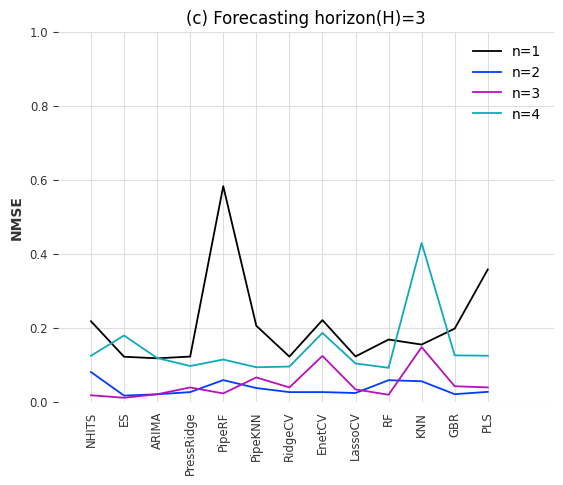

In [ ]:
#H=3
fig,ax = plt.subplots()
x=df1mean.Models
y3=df3mean.MSE
y9=df9mean.MSE
y15=df15mean.MSE
y21=df21mean.MSE
ax.plot(x,y3,label="n=1")
ax.plot(x,y9,label="n=2")
ax.plot(x,y15,label="n=3")
ax.plot(x,y21,label="n=4")
#ax.plot(x,y5,label="h=5")
#ax.plot(x,y6,label="h=6")
#ax.plot(x,y7,label="h=7")
plt.title("(c) Forecasting horizon(H)=3")
plt.ylabel("NMSE")
plt.xticks(rotation=90)
plt.axis([-1, 14, 0, 1])
ax.legend()
plt.show()

H=4

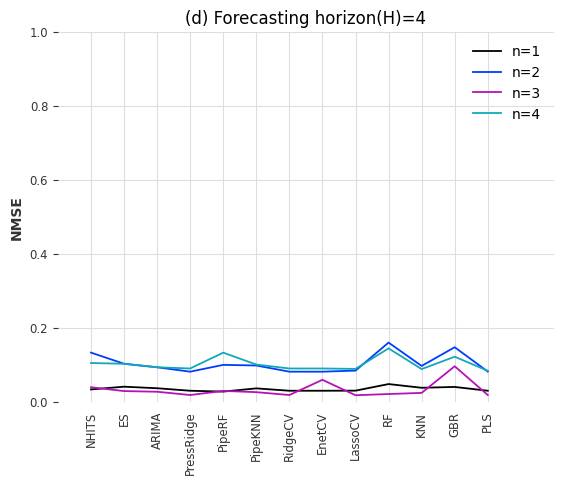

In [ ]:
#H=4
fig,ax = plt.subplots()
x=df1mean.Models
y4=df4mean.MSE
y10=df10mean.MSE
y16=df16mean.MSE
y22=df22mean.MSE
ax.plot(x,y4,label="n=1")
ax.plot(x,y10,label="n=2")
ax.plot(x,y16,label="n=3")
ax.plot(x,y22,label="n=4")
#ax.plot(x,y5,label="h=5")
#ax.plot(x,y6,label="h=6")
#ax.plot(x,y7,label="h=7")
plt.title("(d) Forecasting horizon(H)=4")
plt.ylabel("NMSE")
plt.xticks(rotation=90)
plt.axis([-1, 14, 0, 1])
ax.legend()
plt.show()

H=5

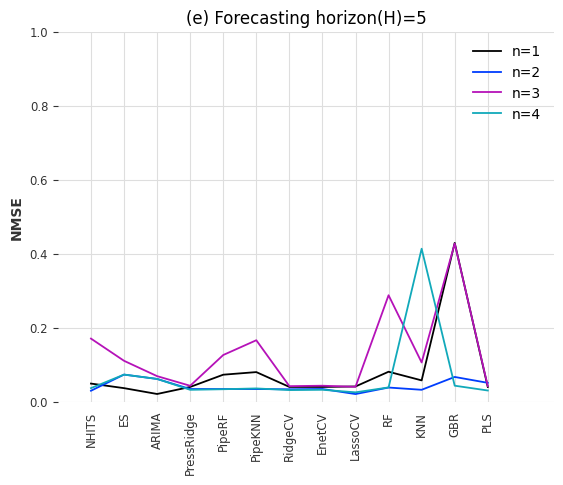

In [ ]:
#H=5
fig,ax = plt.subplots()
x=df1mean.Models
y5=df5mean.MSE
y11=df11mean.MSE
y17=df17mean.MSE
y23=df23mean.MSE
ax.plot(x,y5,label="n=1")
ax.plot(x,y11,label="n=2")
ax.plot(x,y17,label="n=3")
ax.plot(x,y23,label="n=4")
#ax.plot(x,y5,label="h=5")
#ax.plot(x,y6,label="h=6")
#ax.plot(x,y7,label="h=7")
plt.title("(e) Forecasting horizon(H)=5")
plt.ylabel("NMSE")
plt.xticks(rotation=90)
plt.axis([-1, 14, 0, 1])
ax.legend()
plt.show()

H=6

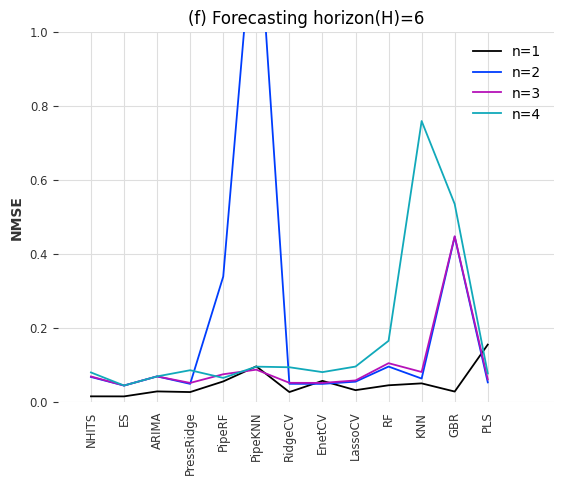

In [ ]:
#H=6
fig,ax = plt.subplots()
x=df1mean.Models
y6=df6mean.MSE
y12=df12mean.MSE
y18=df18mean.MSE
y24=df24mean.MSE
ax.plot(x,y6,label="n=1")
ax.plot(x,y12,label="n=2")
ax.plot(x,y18,label="n=3")
ax.plot(x,y24,label="n=4")
#ax.plot(x,y5,label="h=5")
#ax.plot(x,y6,label="h=6")
#ax.plot(x,y7,label="h=7")
plt.title("(f) Forecasting horizon(H)=6")
plt.ylabel("NMSE")
plt.xticks(rotation=90)
plt.axis([-1, 14, 0, 1])
ax.legend()
plt.show()

n=2

In [ ]:
df7=pandas.read_pickle("./MSEn2h1.pdata")
df7.mean()
df7mean=df7.mean().to_frame()
df7mean.columns=['MSE']
df7mean=df7mean.reset_index(names=['Models','MSE'])
df7mean

,Models,MSE
0,NHITS,0.389865
1,ES,0.575854
2,ARIMA,0.035342
3,PressRidge,0.026139
4,PipeRF,0.357786
5,PipeKNN,0.345127
6,RidgeCV,0.026469
7,EnetCV,0.783029
8,LassoCV,0.044060
9,RF,0.068046


In [ ]:
df8=pandas.read_pickle("./MSEn2h2.pdata")
df8.mean()
df8mean=df8.mean().to_frame()
df8mean.columns=['MSE']
df8mean=df8mean.reset_index(names=['Models','MSE'])
df8mean

,Models,MSE
0,NHITS,0.021649
1,ES,0.013065
2,ARIMA,0.008385
3,PressRidge,0.006926
4,PipeRF,0.044293
5,PipeKNN,0.054685
6,RidgeCV,0.006938
7,EnetCV,0.006924
8,LassoCV,0.008079
9,RF,0.017989


In [ ]:
df9=pandas.read_pickle("./MSEn2h3.pdata")
df9.mean()
df9mean=df9.mean().to_frame()
df9mean.columns=['MSE']
df9mean=df9mean.reset_index(names=['Models','MSE'])
df9mean

,Models,MSE
0,NHITS,0.100541
1,ES,0.178601
2,ARIMA,0.117685
3,PressRidge,0.100278
4,PipeRF,0.132988
5,PipeKNN,0.085935
6,RidgeCV,0.099235
7,EnetCV,0.152667
8,LassoCV,0.107847
9,RF,0.089627


In [ ]:
df10=pandas.read_pickle("./MSEn2h4.pdata")
df10.mean()
df10mean=df10.mean().to_frame()
df10mean.columns=['MSE']
df10mean=df10mean.reset_index(names=['Models','MSE'])
df10mean

,Models,MSE
0,NHITS,0.029821
1,ES,0.011326
2,ARIMA,0.016610
3,PressRidge,0.016846
4,PipeRF,0.028644
5,PipeKNN,0.064984
6,RidgeCV,0.016843
7,EnetCV,0.016847
8,LassoCV,0.016801
9,RF,0.033580


In [ ]:
df11=pandas.read_pickle("./MSEn2h5.pdata")
df11.mean()
df11mean=df11.mean().to_frame()
df11mean.columns=['MSE']
df11mean=df11mean.reset_index(names=['Models','MSE'])
df11mean

,Models,MSE
0,NHITS,0.263621
1,ES,0.060925
2,ARIMA,0.090976
3,PressRidge,0.067555
4,PipeRF,0.137452
5,PipeKNN,0.122680
6,RidgeCV,0.067594
7,EnetCV,0.067551
8,LassoCV,0.077222
9,RF,0.165406


In [ ]:
df12=pandas.read_pickle("./MSEn2h6.pdata")
df12.mean()
df12mean=df12.mean().to_frame()
df12mean.columns=['MSE']
df12mean=df12mean.reset_index(names=['Models','MSE'])
df12mean

,Models,MSE
0,NHITS,0.047688
1,ES,0.043255
2,ARIMA,0.067996
3,PressRidge,0.047814
4,PipeRF,0.338152
5,PipeKNN,1.392932
6,RidgeCV,0.047935
7,EnetCV,0.047801
8,LassoCV,0.053703
9,RF,0.094613


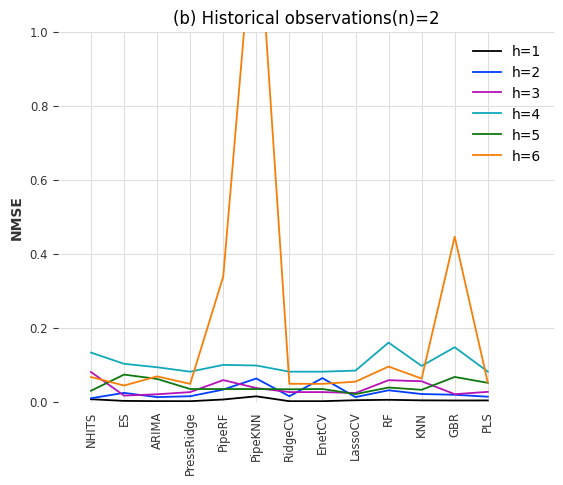

In [ ]:
#n=2
fig,ax = plt.subplots()
x=df1mean.Models
y7=df7mean.MSE
y8=df8mean.MSE
y9=df9mean.MSE
y10=df10mean.MSE
y11=df11mean.MSE
y12=df12mean.MSE
#y7=dfmean7.MSE
ax.plot(x,y7,label="h=1")
ax.plot(x,y8,label="h=2")
ax.plot(x,y9,label="h=3")
ax.plot(x,y10,label="h=4")
ax.plot(x,y11,label="h=5")
ax.plot(x,y12,label="h=6")
#ax.plot(x,y7,label="h=7")
plt.title("(b) Historical observations(n)=2")
plt.ylabel("NMSE")
plt.xticks(rotation=90)
plt.axis([-1, 14, 0, 1])
ax.legend()
plt.show()

n=3

In [ ]:
df13=pandas.read_pickle("./MSEn3h1.pdata")
df13.mean()
df13mean=df13.mean().to_frame()
df13mean.columns=['MSE']
df13mean=df13mean.reset_index(names=['Models','MSE'])
df13mean

,Models,MSE
0,NHITS,0.006928
1,ES,0.001565
2,ARIMA,0.000171
3,PressRidge,0.000270
4,PipeRF,0.001573
5,PipeKNN,0.005006
6,RidgeCV,0.000277
7,EnetCV,0.000269
8,LassoCV,0.001698
9,RF,0.003371


In [ ]:
df14=pandas.read_pickle("./MSEn3h2.pdata")
df14.mean()
df14mean=df14.mean().to_frame()
df14mean.columns=['MSE']
df14mean=df14mean.reset_index(names=['Models','MSE'])
df14mean

,Models,MSE
0,NHITS,0.020397
1,ES,0.023362
2,ARIMA,0.011947
3,PressRidge,0.013824
4,PipeRF,0.029353
5,PipeKNN,0.014175
6,RidgeCV,0.013794
7,EnetCV,0.059930
8,LassoCV,0.011560
9,RF,0.024159


In [ ]:
df15=pandas.read_pickle("./MSEn3h3.pdata")
df15.mean()
df15mean=df15.mean().to_frame()
df15mean.columns=['MSE']
df15mean=df15mean.reset_index(names=['Models','MSE'])
df15mean

,Models,MSE
0,NHITS,0.018756
1,ES,0.010177
2,ARIMA,0.019676
3,PressRidge,0.038056
4,PipeRF,0.021973
5,PipeKNN,0.065243
6,RidgeCV,0.038095
7,EnetCV,0.123332
8,LassoCV,0.032745
9,RF,0.018381


In [ ]:
df16=pandas.read_pickle("./MSEn3h4.pdata")
df16.mean()
df16mean=df16.mean().to_frame()
df16mean.columns=['MSE']
df16mean=df16mean.reset_index(names=['Models','MSE'])
df16mean

,Models,MSE
0,NHITS,0.035713
1,ES,0.028296
2,ARIMA,0.026506
3,PressRidge,0.017565
4,PipeRF,0.028785
5,PipeKNN,0.025354
6,RidgeCV,0.017572
7,EnetCV,0.058743
8,LassoCV,0.016988
9,RF,0.020297


In [ ]:
df17=pandas.read_pickle("./MSEn3h5.pdata")
df17.mean()
df17mean=df17.mean().to_frame()
df17mean.columns=['MSE']
df17mean=df17mean.reset_index(names=['Models','MSE'])
df17mean

,Models,MSE
0,NHITS,0.169783
1,ES,0.110181
2,ARIMA,0.068691
3,PressRidge,0.042630
4,PipeRF,0.125867
5,PipeKNN,0.165828
6,RidgeCV,0.041601
7,EnetCV,0.042748
8,LassoCV,0.039793
9,RF,0.287595


In [ ]:
df18=pandas.read_pickle("./MSEn3h6.pdata")
df18.mean()
df18mean=df18.mean().to_frame()
df18mean.columns=['MSE']
df18mean=df18mean.reset_index(names=['Models','MSE'])
df18mean

,Models,MSE
0,NHITS,0.059626
1,ES,0.043255
2,ARIMA,0.067996
3,PressRidge,0.050370
4,PipeRF,0.073813
5,PipeKNN,0.086196
6,RidgeCV,0.050593
7,EnetCV,0.050345
8,LassoCV,0.057053
9,RF,0.103745


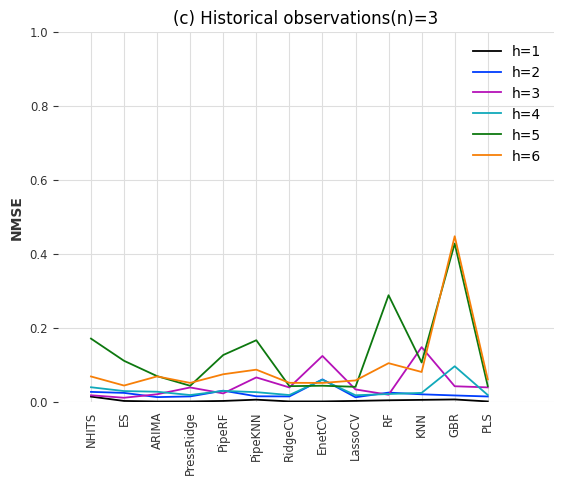

In [ ]:
#n=3
fig,ax = plt.subplots()
x=df1mean.Models
y13=df13mean.MSE
y14=df14mean.MSE
y15=df15mean.MSE
y16=df16mean.MSE
y17=df17mean.MSE
y18=df18mean.MSE
#y7=dfmean7.MSE
ax.plot(x,y13,label="h=1")
ax.plot(x,y14,label="h=2")
ax.plot(x,y15,label="h=3")
ax.plot(x,y16,label="h=4")
ax.plot(x,y17,label="h=5")
ax.plot(x,y18,label="h=6")
#ax.plot(x,y7,label="h=7")
plt.title("(c) Historical observations(n)=3")
plt.ylabel("NMSE")
plt.xticks(rotation=90)
plt.axis([-1, 14, 0, 1])
ax.legend()
plt.show()

n=4

In [ ]:
df19=pandas.read_pickle("./MSEn4h1.pdata")
df19.mean()
df19mean=df19.mean().to_frame()
df19mean.columns=['MSE']
df19mean=df19mean.reset_index(names=['Models','MSE'])
df19mean

In [ ]:
df20=pandas.read_pickle("./MSEn4h2.pdata")
df20.mean()
df20mean=df20.mean().to_frame()
df20mean.columns=['MSE']
df20mean=df20mean.reset_index(names=['Models','MSE'])
df20mean

In [ ]:
df21=pandas.read_pickle("./MSEn4h3.pdata")
df21.mean()
df21mean=df21.mean().to_frame()
df21mean.columns=['MSE']
df21mean=df21mean.reset_index(names=['Models','MSE'])
df21mean

In [ ]:
df22=pandas.read_pickle("./MSEn4h4.pdata")
df22.mean()
df22mean=df22.mean().to_frame()
df22mean.columns=['MSE']
df22mean=df22mean.reset_index(names=['Models','MSE'])
df22mean

In [ ]:
df23=pandas.read_pickle("./MSEn4h5.pdata")
df23.mean()
df23mean=df23.mean().to_frame()
df23mean.columns=['MSE']
df23mean=df23mean.reset_index(names=['Models','MSE'])
df23mean

In [ ]:
df24=pandas.read_pickle("./MSEn4h6.pdata")
df24.mean()
df24mean=df24.mean().to_frame()
df24mean.columns=['MSE']
df24mean=df24mean.reset_index(names=['Models','MSE'])
df24mean

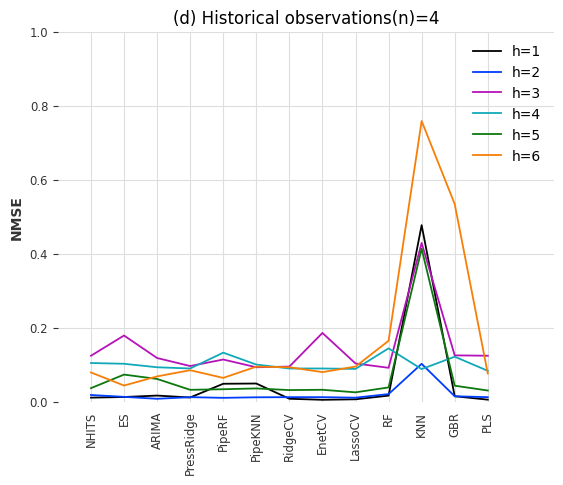

In [ ]:
#n=4
fig,ax = plt.subplots()
x=df19mean.Models
y19=df19mean.MSE
y20=df20mean.MSE
y21=df21mean.MSE
y22=df22mean.MSE
y23=df23mean.MSE
y24=df24mean.MSE
#y7=dfmean7.MSE
ax.plot(x,y19,label="h=1")
ax.plot(x,y20,label="h=2")
ax.plot(x,y21,label="h=3")
ax.plot(x,y22,label="h=4")
ax.plot(x,y23,label="h=5")
ax.plot(x,y24,label="h=6")
#ax.plot(x,y7,label="h=7")
plt.title("(d) Historical observations(n)=4")
plt.ylabel("NMSE")
plt.xticks(rotation=90)
plt.axis([-1, 14, 0, 1])
ax.legend()
plt.show()

In [ ]:
df__=pandas.read_pickle("./MSEn5h20.pdata")
df__.mean()
dfmean__=df__.mean().to_frame()
dfmean__.columns=['MSE']
dfmean__=dfmean__.reset_index(names=['Models','MSE'])
dfmean__

,Models,MSE
0,NHITS,0.220637
1,ES,0.892088
2,ARIMA,0.625055
3,PressRidge,0.139710
4,PipeRF,0.085866
5,PipeKNN,0.223111
6,RidgeCV,0.139960
7,EnetCV,0.185758
8,LassoCV,0.168353
9,RF,0.156037


In [ ]:
df24= pandas.read_pickle("./MSEn10h20.pdata")
df24.mean()
dfmean24=df24.mean().to_frame()
dfmean24.columns=['MSE']
dfmean24=dfmean24.reset_index(names=['Models','MSE'])
dfmean24

,Models,MSE
0,NHITS,2.578284
1,ES,3.173614
2,ARIMA,3.553840
3,PressRidge,1.153264
4,PipeRF,1.202709
5,PipeKNN,1.121505
6,RidgeCV,1.268597
7,EnetCV,1.170498
8,LassoCV,1.171683
9,RF,1.134221


In [ ]:
dfmean1,dfmean2

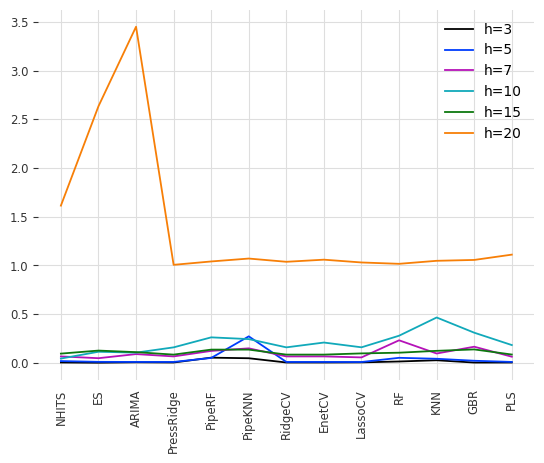

In [ ]:
#n=3
fig,ax = plt.subplots()
x=dfmean1.Models
y1=dfmean1.MSE
y2=dfmean2.MSE
y3=dfmean3.MSE
y4=dfmean4.MSE
y5=dfmean5.MSE
y6=dfmean6.MSE
#y7=dfmean7.MSE
ax.plot(x,y1,label="h=3")
ax.plot(x,y2,label="h=5")
ax.plot(x,y3,label="h=7")
ax.plot(x,y4,label="h=10")
ax.plot(x,y5,label="h=15")
ax.plot(x,y6,label="h=20")
#ax.plot(x,y7,label="h=7")
plt.xticks(rotation=90)
ax.legend()
plt.show()

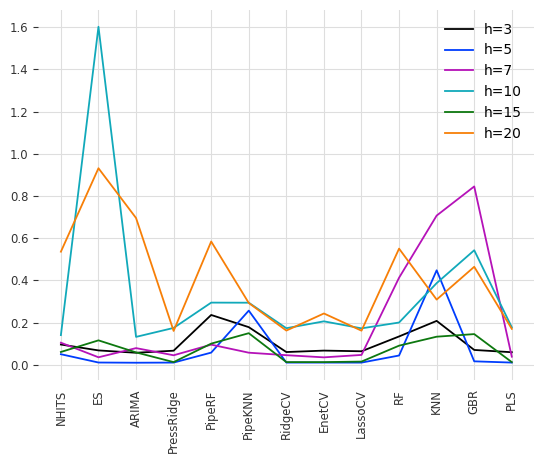

In [ ]:
n=5
fig,ax = plt.subplots()
x=dfmean1.Models
y7=dfmean7.MSE
y8=dfmean8.MSE
y9=dfmean9.MSE
y10=dfmean10.MSE
y11=dfmean11.MSE
y12=dfmean12.MSE
#y7=dfmean7.MSE
ax.plot(x,y7,label="h=3")
ax.plot(x,y8,label="h=5")
ax.plot(x,y9,label="h=7")
ax.plot(x,y10,label="h=10")
ax.plot(x,y11,label="h=15")
ax.plot(x,y12,label="h=20")
#ax.plot(x,y7,label="h=7")
plt.xticks(rotation=90)
ax.legend()
plt.show()

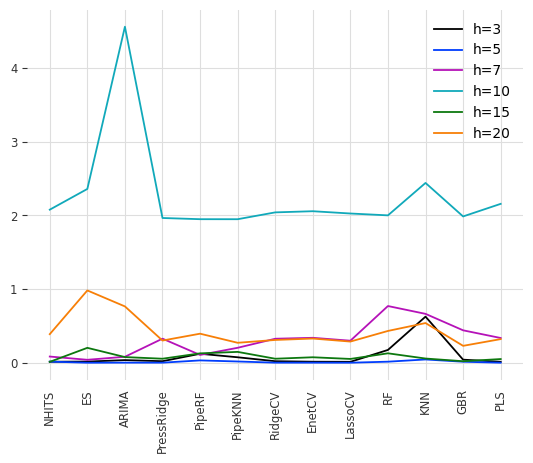

In [ ]:
#n=7
fig,ax = plt.subplots()
x=dfmean1.Models
y13=dfmean13.MSE
y14=dfmean14.MSE
y15=dfmean15.MSE
y16=dfmean16.MSE
y17=dfmean17.MSE
y18=dfmean18.MSE
#y19=dfmean19.MSE
#y7=dfmean7.MSE
ax.plot(x,y13,label="h=3")
ax.plot(x,y14,label="h=5")
ax.plot(x,y15,label="h=7")
ax.plot(x,y16,label="h=10")
ax.plot(x,y17,label="h=15")
ax.plot(x,y18,label="h=20")
#ax.plot(x,y7,label="h=7")
plt.xticks(rotation=90)
ax.legend()
plt.show()

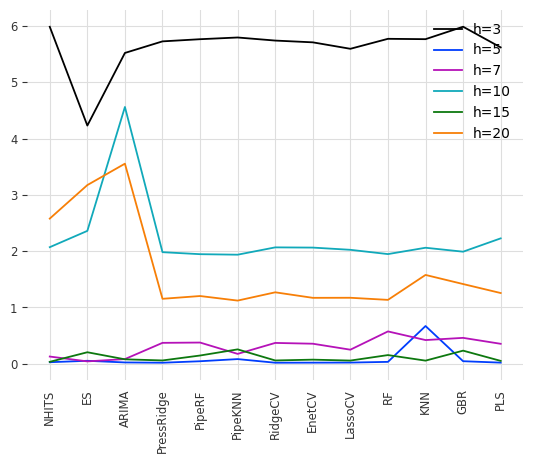

In [ ]:
#n=10
fig,ax = plt.subplots()
x=dfmean1.Models
y19=dfmean19.MSE
y20=dfmean20.MSE
y21=dfmean21.MSE
y22=dfmean22.MSE
y23=dfmean23.MSE
y24=dfmean24.MSE
#y7=dfmean7.MSE
ax.plot(x,y19,label="h=3")
ax.plot(x,y20,label="h=5")
ax.plot(x,y21,label="h=7")
ax.plot(x,y22,label="h=10")
ax.plot(x,y23,label="h=15")
ax.plot(x,y24,label="h=20")
#ax.plot(x,y7,label="h=7")
plt.xticks(rotation=90)
ax.legend()
plt.show()

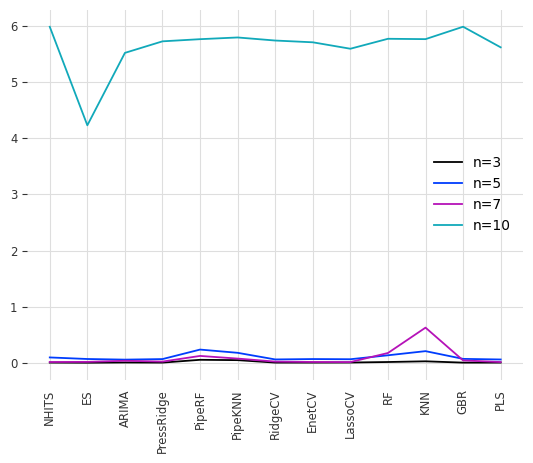

In [ ]:
#H=3
fig,ax = plt.subplots()
x=dfmean1.Models
y1=dfmean1.MSE
y7=dfmean7.MSE
y13=dfmean13.MSE
y19=dfmean19.MSE
#y24=dfmean24.MSE
#y25=dfmean25.MSE
#y7=dfmean7.MSE
ax.plot(x,y1,label="n=3")
ax.plot(x,y7,label="n=5")
ax.plot(x,y13,label="n=7")
ax.plot(x,y19,label="n=10")
#ax.plot(x,y24,label="h=15")
#ax.plot(x,y25,label="h=20")
#ax.plot(x,y7,label="h=7")
plt.xticks(rotation=90)
ax.legend()
plt.show()

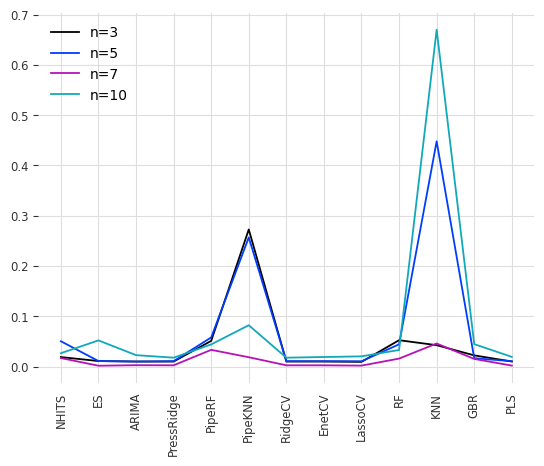

In [ ]:
#H=5
fig,ax = plt.subplots()
x=dfmean1.Models
y2=dfmean2.MSE
y8=dfmean8.MSE
y14=dfmean14.MSE
y20=dfmean20.MSE
#y24=dfmean24.MSE
#y25=dfmean25.MSE
#y7=dfmean7.MSE
ax.plot(x,y2,label="n=3")
ax.plot(x,y8,label="n=5")
ax.plot(x,y14,label="n=7")
ax.plot(x,y20,label="n=10")
#ax.plot(x,y24,label="h=15")
#ax.plot(x,y25,label="h=20")
#ax.plot(x,y7,label="h=7")
plt.xticks(rotation=90)
ax.legend()
plt.show()

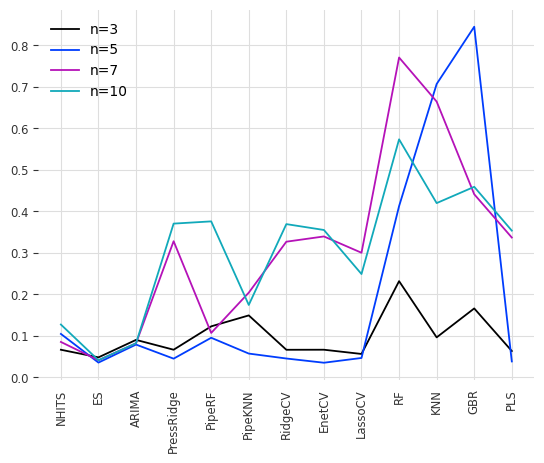

In [ ]:
#H=7
fig,ax = plt.subplots()
x=dfmean1.Models
y3=dfmean3.MSE
y9=dfmean9.MSE
y15=dfmean15.MSE
y21=dfmean21.MSE
#y24=dfmean24.MSE
#y25=dfmean25.MSE
#y7=dfmean7.MSE
ax.plot(x,y3,label="n=3")
ax.plot(x,y9,label="n=5")
ax.plot(x,y15,label="n=7")
ax.plot(x,y21,label="n=10")
#ax.plot(x,y24,label="h=15")
#ax.plot(x,y25,label="h=20")
#ax.plot(x,y7,label="h=7")
plt.xticks(rotation=90)
ax.legend()
plt.show()

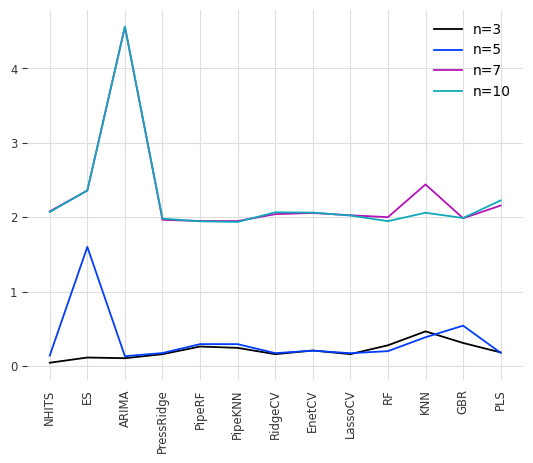

In [ ]:
#H=10
fig,ax = plt.subplots()
x=dfmean1.Models
y4=dfmean4.MSE
y10=dfmean10.MSE
y16=dfmean16.MSE
y22=dfmean22.MSE
#y24=dfmean24.MSE
#y25=dfmean25.MSE
#y7=dfmean7.MSE
ax.plot(x,y4,label="n=3")
ax.plot(x,y10,label="n=5")
ax.plot(x,y16,label="n=7")
ax.plot(x,y22,label="n=10")
#ax.plot(x,y24,label="h=15")
#ax.plot(x,y25,label="h=20")
#ax.plot(x,y7,label="h=7")
plt.xticks(rotation=90)
ax.legend()
plt.show()

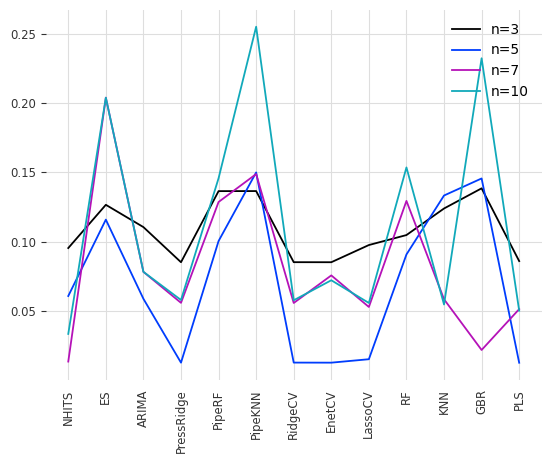

In [ ]:
#H=15
fig,ax = plt.subplots()
x=dfmean1.Models
y5=dfmean5.MSE
y11=dfmean11.MSE
y17=dfmean17.MSE
y23=dfmean23.MSE
#y24=dfmean24.MSE
#y25=dfmean25.MSE
#y7=dfmean7.MSE
ax.plot(x,y5,label="n=3")
ax.plot(x,y11,label="n=5")
ax.plot(x,y17,label="n=7")
ax.plot(x,y23,label="n=10")
#ax.plot(x,y24,label="h=15")
#ax.plot(x,y25,label="h=20")
#ax.plot(x,y7,label="h=7")
plt.xticks(rotation=90)
ax.legend()
plt.show()

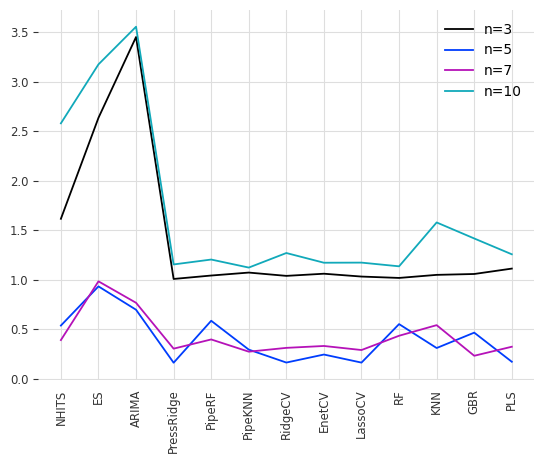

In [ ]:
#H=20
fig,ax = plt.subplots()
x=dfmean1.Models
y6=dfmean6.MSE
y12=dfmean12.MSE
y18=dfmean18.MSE
y24=dfmean24.MSE
#y24=dfmean24.MSE
#y25=dfmean25.MSE
#y7=dfmean7.MSE
ax.plot(x,y6,label="n=3")
ax.plot(x,y12,label="n=5")
ax.plot(x,y18,label="n=7")
ax.plot(x,y24,label="n=10")
#ax.plot(x,y24,label="h=15")
#ax.plot(x,y25,label="h=20")
#ax.plot(x,y7,label="h=7")
plt.xticks(rotation=90)
ax.legend()
plt.show()